In [1]:

#En esta red trato de predecir el metodo anticonceptivo usado por mujeres indonesas segun sus datos demograficos
#y socioeconomicos       Values: 1=No-use, 2=Long-term, 3=Short-term


import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

In [2]:
# FUNCIONES DE ACTIVACION
class function(object):
    def __init__(self,funcion,derivative=None):
        self.F=funcion
        self.D=derivative

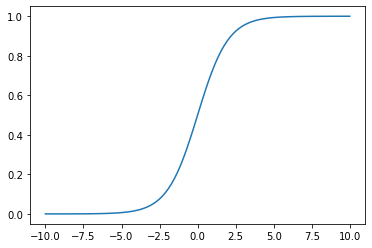

In [3]:


#funciones de activación

def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce



lineal=function(funcion=lambda x:x,derivative=lambda x:1)
sigm=function(funcion=lambda x: 1 / (1 + np.e ** (-x)),derivative=lambda x: x * (1 - x))
tanh=function(funcion=lambda x: 2 / (1 + np.e ** (2*x))-1,derivative=lambda x:1-((2 / (1 + np.e ** (2*x)))-1)**2)

softmax=function(funcion=lambda x: np.exp(x) / np.sum(np.exp(x), axis=0), derivative=lambda x:x*(1-x))
relu=function(funcion=lambda x: np.maximum(0, x) ,derivative=lambda x: np.where(x<=0,0,1))

# funciones de coste
l2_cost=function(funcion=lambda Yp, Yr: np.mean((Yp - Yr) ** 2) ,derivative=lambda Yp, Yr: (Yp - Yr))

_x = np.linspace(-10, 10, 100)#prueba, creo un vector de valores de -10 a 10 de 100 entradas

plt.plot(_x, sigm.F(_x),"tab:blue")



In [5]:
import csv
import random

X=[]
Y=[]
with open('contraceptive_method.csv') as csvfile:
    readCSV = csv.reader(csvfile)
    for row in readCSV:
        X.append([float(row[0])/10,float(row[1])/10,float(row[2])/10,float(row[3])/10,
                 float(row[4])/10,float(row[5])/10,float(row[6])/10,float(row[7])/10,
                 float(row[8])/10])#

        if row[9]=='1':#normalizar salidas
            Y.append([1,0,0]) #no use
        if row[9]=='2':
            Y.append([0,1,0]) #rlong term
        if row[9]=='3':
            Y.append([0,0,1]) #short term

random.shuffle(X)
random.shuffle(Y)

Xtrain=np.array(X)#vector de entradas
Ytrain=np.array(Y)#vector de salida

print(np.shape(Xtrain))
print(np.shape(Ytrain))



(1473, 9)
(1473, 3)


In [6]:
# CLASE DE LA CAPA DE LA RED
from IPython.display import clear_output
import time

class neural_layer():#clase capa neuronal
 
  def __init__(self, n_conn, n_neur, act_f): #numero entradas, numero neuronas, funcion actvacion
    self.act = act_f
    
    self.b = np.random.rand(1, n_neur)      * 2 - 1   #entre 0 y 1 bias, es un vector porque cada neurona tiene un valor
    self.W = np.random.rand(n_conn, n_neur) * 2 - 1   #pesos, numero de entradas y numero de neuronas en esa capa, para cada neurona tiene x pesos
                                                        #es una matriz,
    
# creación de una red neuronal según topologia
def create_nn(topology):
  nn = []
  for l, layer in enumerate(topology[:-1]):#enumerate devuelve el objeto y su indice
    nn.append(neural_layer(topology[l][0], topology[l+1][0], topology[l][1]))#ver codigo de definicion mas abajo en topology
  return nn                               #que entre la capa de 4 y 30 van conectadas
    
# fucnción de predicción (fordware pass)    
def predict(neural_net, X):
  
  out = [(None, X)] #primer data necesario
  
  # Forward pass
  for l, layer in enumerate(neural_net):#para cada indice\capa, ejecutocen cada capa, por eso el for
    z = out[-1][1] @ neural_net[l].W + neural_net[l].b#potencial sinaptico, 
    a = neural_net[l].act.F(z)#funcion de activacion, de su potencial, osea z.
    out.append((z, a))#en out vamos metiendo tanto z como a.
  return out[-1][1]#solo necesitamos devilver la ultima(-1 es la ultima capa). la salida
  
# función retropropagación del error
def backward_pass(neural_net, X, Y, l2_cost, lr=0.5,alpha=1):
  sx=np.shape(X)
  sy=np.shape(Y)
  X=X.reshape(1,sx[0])#pasa de vector a "columna" por asi decirlo, para poder multiplicarlo y luego calcular la traspuesta
  Y=Y.reshape(1,sy[0])
  out = [(None, X)] #primer data necesario
  
  # Forward pass
  for l, layer in enumerate(neural_net):
    z = out[-1][1] @ neural_net[l].W + neural_net[l].b
    a = neural_net[l].act.F(z)
    out.append((z, a))

  # Backward pass 
  deltas = []
  for l in reversed(range(0, len(neural_net))):#reverse recorre al reves las capas, de atras hacia la primera
    z = out[l+1][0]
    a = out[l+1][1]
    if l == len(neural_net) - 1:#si estoy en la ultima capa
      deltas.insert(0, l2_cost.D(a, Y) * neural_net[l].act.D(a))#la primera vz pasa por aqui
    else:
      deltas.insert(0, deltas[0] @ _W.T * neural_net[l-1].act.D(a))# .T es de numpy, es la traspuesta
    _W = neural_net[l].W #los pesos en la capa superior
 
    # Gradient descent
    #neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr   
    neural_net[l].b = neural_net[l].b - (deltas[0]* lr)#bias
    neural_net[l].W = neural_net[l].W - lr * (out[l][1].T @ deltas[0])
  return out[-1][1]#cuando termina el bucle, retorna la salida


# función de entrenamiento de la red
def train(neural_net,X,Y,l2_cost,lr=0.5,epoch=1000,alpha=1,batch_size=1):#en este caso ni alpha ni bartch size estan activos
    loss = []
    ACC =[]
    for i in range(epoch):
        account=0
        # Entrenemos a la red!
        for j in range(len(X)):
            pY = backward_pass(neural_n, X[j,:], Y[j,:], l2_cost, lr,alpha) #devuelve la predicion

            if (Y[j,:]==np.round(pY)).all():#redondea, porque viene en float.  Y[j,:] es nuestra solucion real, pY la prediccion. El punto all devuelve si por ejemplo Y[1,0,0] e pY[0.98,0.1,0,1]  y devuelve true.
                account+=1
        print("Epoch={}, Loss={} Accuracy={}".format(i,round(l2_cost.F(pY,Y[j,:]),15),round(account/len(Y)*100,3)),end="")
        clear_output(wait=True)#no hace notebook el retorno de carro
        ACC.append(account/len(Y)*100)    
        loss.append(l2_cost.F(pY,Y[j,:]))
     
    return loss,ACC

In [35]:
# definicion de la red

#topology = [(9,sigm),(8,sigm),(4,sigm),(3,softmax)] #9
#topology = [(9,sigm),(6,sigm),(3,softmax)]
#topology = [(9,sigm),(32,sigm),(12,sigm),(3,softmax)]
topology = [(9,relu),(48,relu),(32,relu),(12,sigm),(3,softmax)]
#topology = [(9,relu),(120,relu),(80,relu),(30,relu),(10,sigm),(3,sigm)]

neural_n = create_nn(topology)

In [36]:
# FUNCION DE ENTRENAMIENTO

epoch=150
lr=0.01
batch_size=5
momentun=1
loss = []
accuracy=[]

loss,accuracy=train(neural_n,Xtrain,Ytrain,l2_cost,lr,epoch,momentun,batch_size)

Epoch=149, Loss=0.666666665617844 Accuracy=42.702

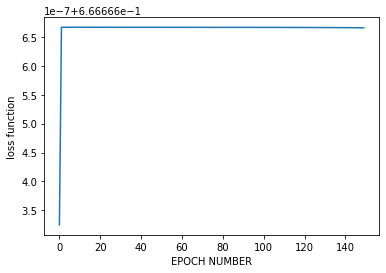

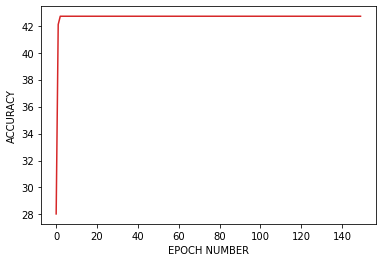

In [37]:
plt.plot(range(len(loss)), loss)
plt.ylabel("loss function")
plt.xlabel("EPOCH NUMBER")
plt.show()
plt.plot(range(len(accuracy)), accuracy, "tab:red")
plt.ylabel("ACCURACY")
plt.xlabel("EPOCH NUMBER")
plt.show()
  

In [38]:
# VISUALIZACIÓN Y TEST
#  ahora podemos interrogar. el primer valor es el bias
def print_predict(X,Y):
    for i in range(len(X)):
        sal=np.round(predict(neural_n,X[i]))
        if (Y[i]==np.round(sal)).all():
            print("Input:{}-- Real:{} predict: {}".format(X[i],Y[i],sal))
        else:
            print("\x1b[31m Input:{}-- Real:{} predict: {}\x1b[0m".format(X[i],Y[i],sal))


print_predict(Xtrain,Ytrain)
print("::::::::::::::::::::::::::::")

 Input:[1.9 0.2 0.4 0.1 0.1 0.1 0.2 0.3 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
Input:[2.1 0.4 0.4 0.1 0.1 0.1 0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.5 0.4 0.4 0.3 0.1 0.1 0.2 0.3 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[4.5 0.3 0.3 0.6 0.  0.1 0.2 0.4 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[4.7 0.1 0.1 0.8 0.1 0.1 0.3 0.4 0.1]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.2 0.1 0.2 0.6 0.  0.1 0.2 0.3 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[2.  0.2 0.2 0.2 0.1 0.1 0.2 0.2 0.1]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.2 0.3 0.4 0.1 0.1 0.1 0.3 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.8 0.4 0.4 0.6 0.  0.1 0.2 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.2 0.3 0.4 0.2 0.1 0.1 0.2 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.7 0.2 0.3 0.5 0.1 0.1 0.4 0.2 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[4.5 0.3 0.3 0.5 0.  0.1 0.1 0.3 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[2.1 0.4 0.4 0.

 Input:[3.  0.4 0.4 0.2 0.  0.  0.1 0.4 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[2.6 0.3 0.4 0.2 0.1 0.1 0.3 0.3 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[2.7 0.4 0.4 0.3 0.1 0.1 0.1 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[3.2 0.4 0.4 0.2 0.  0.  0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[4.8 0.4 0.4 1.6 0.1 0.1 0.1 0.4 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[3.8 0.4 0.4 0.6 0.1 0.1 0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[2.6 0.4 0.4 0.3 0.1 0.1 0.3 0.2 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
Input:[3.6 0.2 0.3 0.6 0.1 0.1 0.2 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.  0.4 0.4 0.4 0.1 0.1 0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.1 0.1 0.4 0.5 0.1 0.  0.2 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.4 0.2 0.3 0.3 0.1 0.  0.3 0.2 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[3.3 0.3 0.4 0.6 0.1 0.1 0.3 0.2 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[4.7 0.4 0.4 0.1

Input:[4.2 0.3 0.3 1.  0.1 0.1 0.3 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.2 0.3 0.4 0.4 0.1 0.1 0.1 0.4 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[2.9 0.2 0.4 0.2 0.1 0.  0.4 0.4 0.1]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[3.1 0.4 0.4 0.3 0.1 0.1 0.1 0.4 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[3.7 0.4 0.4 0.7 0.1 0.1 0.1 0.4 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[3.3 0.4 0.4 0.4 0.1 0.1 0.2 0.3 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[3.7 0.4 0.4 0.5 0.1 0.1 0.3 0.4 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
Input:[4.  0.1 0.1 0.2 0.1 0.  0.3 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.2 0.3 0.3 0.4 0.  0.1 0.3 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.6 0.4 0.4 0.4 0.  0.1 0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.8 0.3 0.4 0.3 0.1 0.1 0.2 0.1 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.4 0.2 0.2 0.9 0.1 0.  0.2 0.3 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
Input:[2.1 0.3 0.4 0.

Input:[3.5 0.4 0.4 0.4 0.  0.  0.1 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[3.6 0.2 0.3 0.5 0.1 0.1 0.2 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[4.3 0.2 0.3 0.3 0.  0.1 0.2 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.1 0.3 0.4 0.  0.1 0.1 0.2 0.3 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.8 0.4 0.4 0.5 0.1 0.1 0.2 0.1 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[3.8 0.4 0.4 0.4 0.  0.  0.1 0.2 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[2.6 0.2 0.3 0.3 0.1 0.1 0.3 0.1 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
Input:[2.6 0.4 0.4 0.1 0.1 0.  0.2 0.4 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
Input:[2.5 0.2 0.2 0.1 0.1 0.1 0.3 0.1 0. ]-- Real:[1 0 0] predict: [[1. 0. 0.]]
 Input:[2.6 0.2 0.4 0.  0.1 0.1 0.3 0.1 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[2.7 0.2 0.4 0.4 0.1 0.1 0.3 0.4 0. ]-- Real:[0 1 0] predict: [[1. 0. 0.]]
 Input:[2.8 0.4 0.4 0.1 0.1 0.  0.1 0.3 0. ]-- Real:[0 0 1] predict: [[1. 0. 0.]]
 Input:[2.1 0.3 0.4 0.2